In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

In [9]:
ChampionTbl = pd.read_csv('archive_game/ChampionTbl.csv')
ItemTbl = pd.read_csv('archive_game/ItemTbl.csv')
MatchStatsTbl = pd.read_csv('archive_game/MatchStatsTbl.csv')
MatchTbl = pd.read_csv('archive_game/MatchTbl.csv')
RankTbl = pd.read_csv('archive_game/RankTbl.csv')
SummonerMatchTbl = pd.read_csv('archive_game/SummonerMatchTbl.csv')
TeamMatchTbl = pd.read_csv('archive_game/TeamMatchTbl.csv')

In [86]:
# Quick inspection of one of the datasets
print('Rank data shape:', RankTbl.shape)
print('MatchStats data shape:', MatchStatsTbl.shape)
print(MatchStatsTbl.head())
print(MatchStatsTbl.describe())

Rank data shape: (11, 2)
MatchStats data shape: (78863, 34)
   MatchStatsId  SummonerMatchFk  MinionsKilled  DmgDealt  DmgTaken  \
0             1                1             30      4765     12541   
1             2                2             29      8821     14534   
2             3                3             34      6410     19011   
3             4                4             51     22206     14771   
4             5                5              0     39106     33572   

   TurretDmgDealt  TotalGold    Lane  Win  item1  ...  SummonerSpell1  \
0               0       7058  BOTTOM    0   3870  ...               4   
1               1       9618  BOTTOM    0   3870  ...               4   
2               3       9877  BOTTOM    1   3870  ...               4   
3               3      12374    NONE    1   6655  ...               4   
4               0      15012     TOP    1   4015  ...            2202   

   SummonerSpell2  CurrentMasteryPoints  EnemyChampionFk  DragonKills  \
0

In [ ]:
#Gắn tên champion vào MatchStats
stats = MatchStatsTbl.merge(SummonerMatchTbl, left_on='SummonerMatchFk', right_on='SummonerMatchId', how='left')
stats = stats.merge(ChampionTbl, left_on='ChampionFk', right_on='ChampionId', how='left')
stats = stats.merge(MatchTbl[['MatchId', 'Patch', 'QueueType']], left_on='MatchFk', right_on='MatchId', how='left')

# Gắn tên enemy champion
stats = stats.merge(ChampionTbl, left_on='EnemyChampionFk', right_on='ChampionId', suffixes=('_Player', '_Enemy'), how='left')

# Chỉ lấy Ranked Solo/Duo (CLASSIC) để phân tích chính xác meta
ranked_stats = stats[stats['QueueType'] == 'CLASSIC'].copy()

C:\Users\Admin\AppData\Local\Temp\ipykernel_8012\3734624347.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=champ_winrate, y='Champion', x='WinRate', palette='viridis', ax=ax1)


[Text(3, 0, '0.6%')]

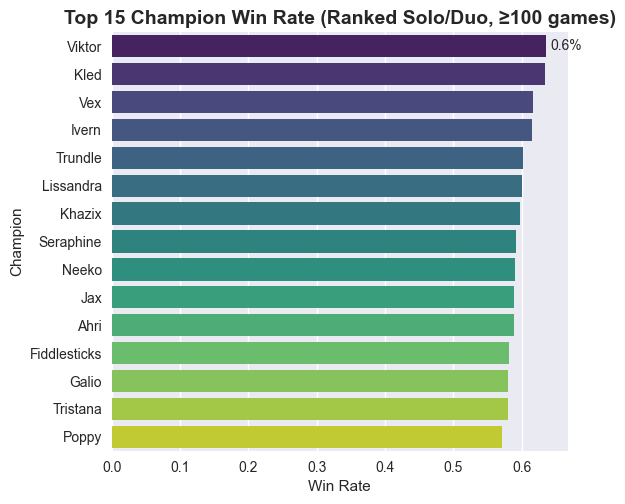

In [ ]:
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 25))

# Top 15 Champion có tỷ lệ thắng cao nhất (ít nhất 100 trận)
champ_winrate = ranked_stats.groupby(['ChampionName_Player']).agg({
    'Win': ['count', 'mean']
}).reset_index()
champ_winrate.columns = ['Champion', 'Games', 'WinRate']
champ_winrate = champ_winrate[champ_winrate['Games'] >= 100].sort_values('WinRate', ascending=False).head(15)

ax1 = plt.subplot(4, 3, 1)
sns.barplot(data=champ_winrate, y='Champion', x='WinRate', palette='viridis', ax=ax1)
ax1.set_title('Top 15 Champion Win Rate (Ranked Solo/Duo, ≥100 games)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Win Rate')
ax1.bar_label(ax1.containers[0], fmt='%.1f%%', padding=3)

[Text(3, 0, '1411'),
 Text(3, 0, '877'),
 Text(3, 0, '816'),
 Text(3, 0, '758'),
 Text(3, 0, '705'),
 Text(3, 0, '698'),
 Text(3, 0, '693'),
 Text(3, 0, '661'),
 Text(3, 0, '657'),
 Text(3, 0, '655'),
 Text(3, 0, '646'),
 Text(3, 0, '636'),
 Text(3, 0, '633'),
 Text(3, 0, '623'),
 Text(3, 0, '601')]

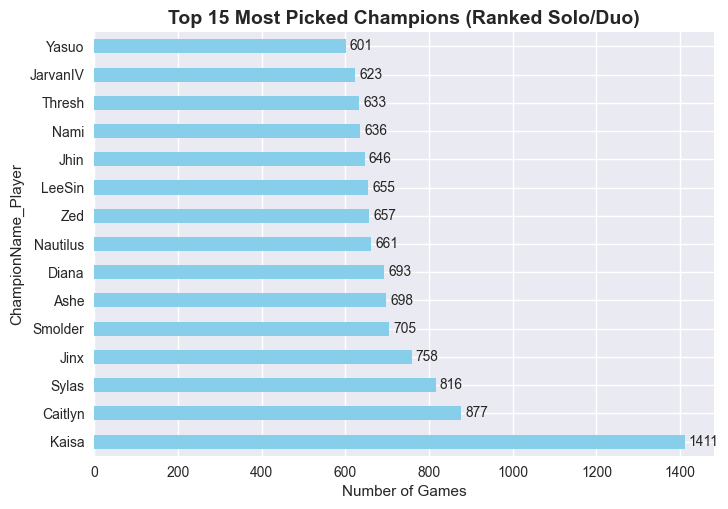

In [ ]:
# Top 15 Champion được chơi nhiều nhất
champ_pickrate = ranked_stats['ChampionName_Player'].value_counts().head(15)

ax2 = plt.subplot(1, 1, 1)
champ_pickrate.plot(kind='barh', color='skyblue', ax=ax2)
ax2.set_title('Top 15 Most Picked Champions (Ranked Solo/Duo)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Games')
ax2.bar_label(ax2.containers[0], padding=3)

Text(0, 0.5, 'Frequency')

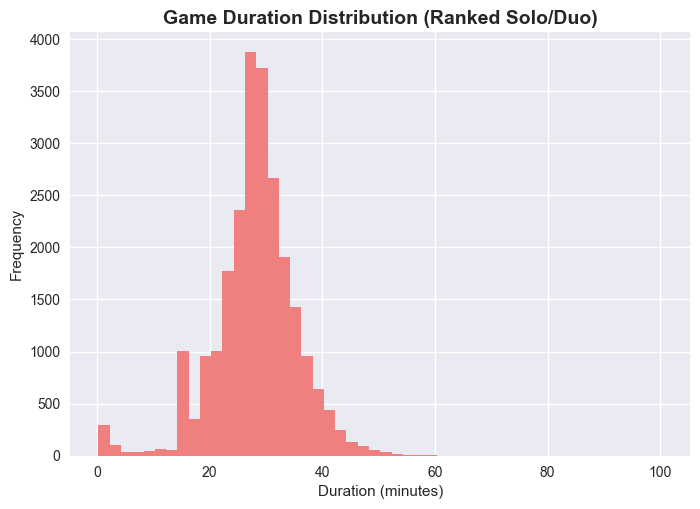

In [ ]:
# Phân bố thời gian trận đấu
ax4 = plt.subplot(1,1,1)
MatchTbl[MatchTbl['QueueType'] == 'CLASSIC']['GameDuration'].div(60).hist(bins=50, color='lightcoral', ax=ax4)
ax4.set_title('Game Duration Distribution (Ranked Solo/Duo)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Duration (minutes)')
ax4.set_ylabel('Frequency')

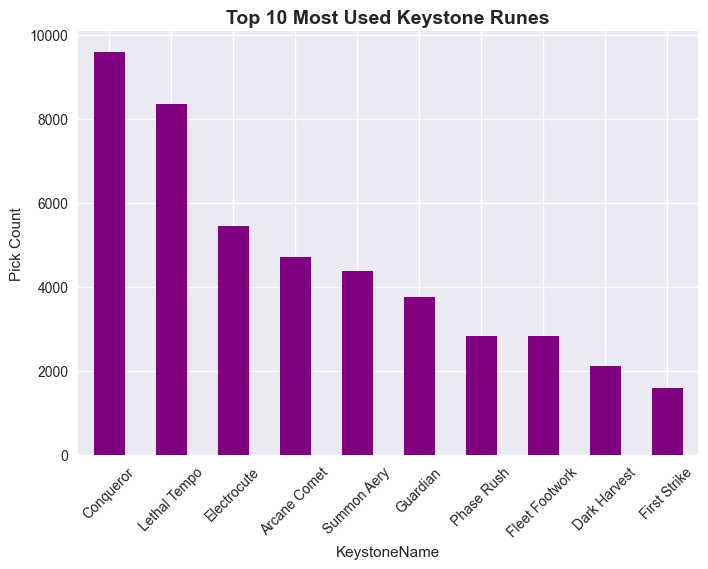

In [ ]:
# Top 10 Keystone Rune phổ biến nhất
keystone_names = {
    8112: 'Electrocute', 8128: 'Dark Harvest', 8214: 'Summon Aery', 8229: 'Arcane Comet',
    8230: 'Phase Rush', 8369: 'First Strike', 8360: 'Unsealed Spellbook', 8008: 'Lethal Tempo',
    8010: 'Conqueror', 8021: 'Fleet Footwork', 9923: 'Hail of Blades', 8351: 'Glacial Augment',
    8124: 'Predator', 8105: 'Grasp of the Undying', 8437: 'Guardian', 8465: 'Press the Attack'
}

ranked_stats['KeystoneName'] = ranked_stats['PrimaryKeyStone'].map(keystone_names)

ax5 = plt.subplot(1, 1, 1)
top_keystones = ranked_stats['KeystoneName'].value_counts().head(10)
top_keystones.plot(kind='bar', color='purple', ax=ax5)
ax5.set_title('Top 10 Most Used Keystone Runes', fontsize=14, fontweight='bold')
ax5.set_ylabel('Pick Count')
ax5.tick_params(axis='x', rotation=45)

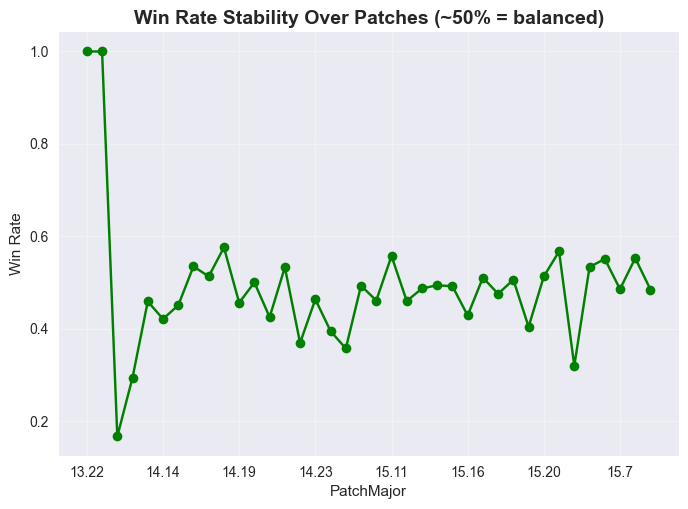

In [ ]:
# Win Rate theo Patch (xem meta thay đổi)
ranked_stats['PatchMajor'] = ranked_stats['Patch'].str.split('.').str[0] + '.' + ranked_stats['Patch'].str.split('.').str[1]
patch_winrate = ranked_stats.groupby('PatchMajor')['Win'].mean()

ax7 = plt.subplot(1,1,1)
patch_winrate.plot(kind='line', marker='o', color='green', ax=ax7)
ax7.set_title('Win Rate Stability Over Patches (~50% = balanced)', fontsize=14, fontweight='bold')
ax7.set_ylabel('Win Rate')
ax7.grid(True, alpha=0.3)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8012\510251362.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kda_top['KDA'] = (kda_top['kills'] + kda_top['assists']) / np.where(kda_top['deaths'] == 0, 1, kda_top['deaths'])


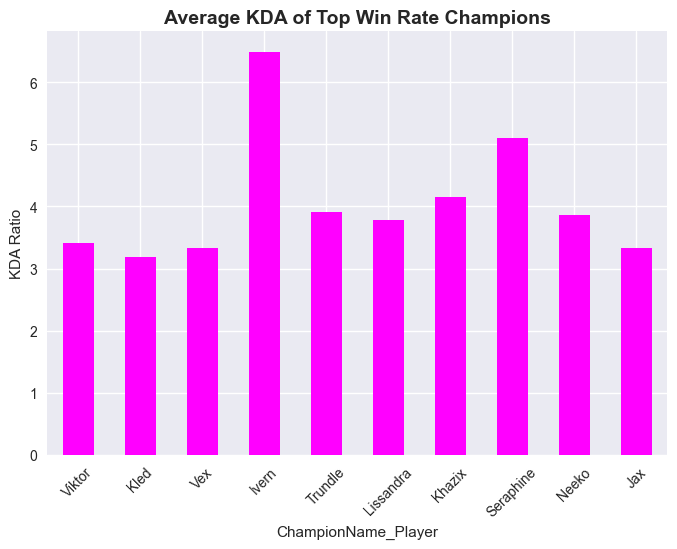

In [ ]:
# KDA trung bình của các champion mạnh nhất
top_champs = champ_winrate.head(10)['Champion'].tolist()
kda_top = ranked_stats[ranked_stats['ChampionName_Player'].isin(top_champs)]
kda_top['KDA'] = (kda_top['kills'] + kda_top['assists']) / np.where(kda_top['deaths'] == 0, 1, kda_top['deaths'])

ax10 = plt.subplot(1,1,1)
kda_mean = kda_top.groupby('ChampionName_Player')['KDA'].mean().loc[top_champs]
kda_mean.plot(kind='bar', color='magenta', ax=ax10)
ax10.set_title('Average KDA of Top Win Rate Champions', fontsize=14, fontweight='bold')
ax10.set_ylabel('KDA Ratio')
ax10.tick_params(axis='x', rotation=45)

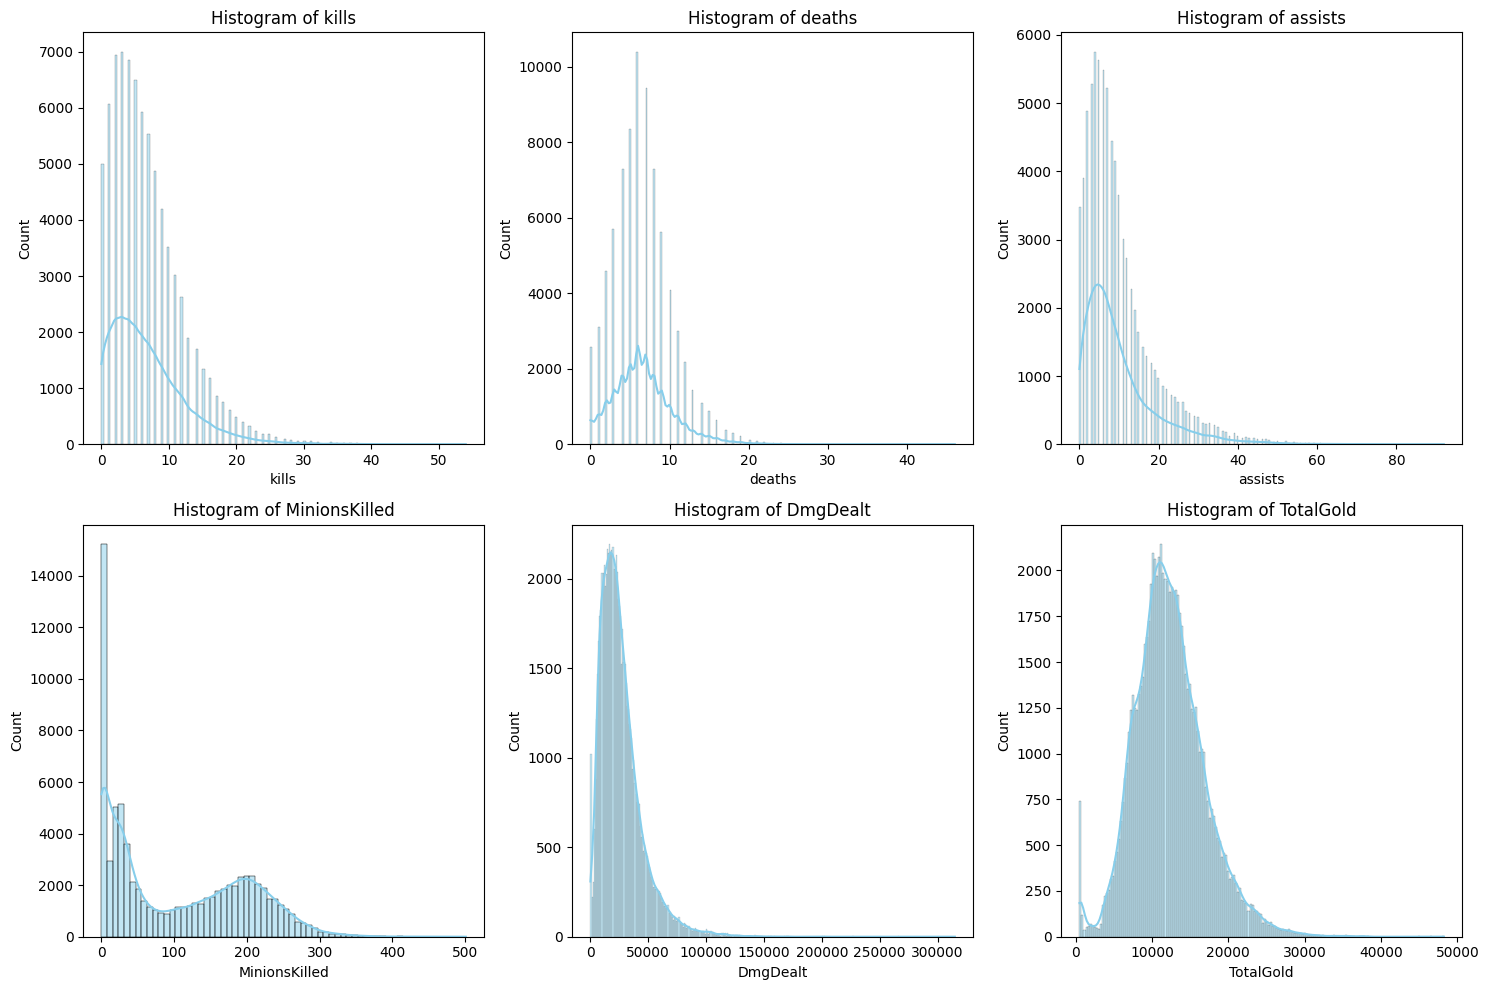

In [23]:
# Plot histograms for a few important metrics
metrics = ['kills', 'deaths', 'assists', 'MinionsKilled', 'DmgDealt', 'TotalGold']
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.histplot(MatchStatsTbl[metric], kde=True, color='skyblue')
    plt.title(f'Histogram of {metric}')
plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_8012\4062339472.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Lane', data=MatchStatsTbl, palette='pastel')


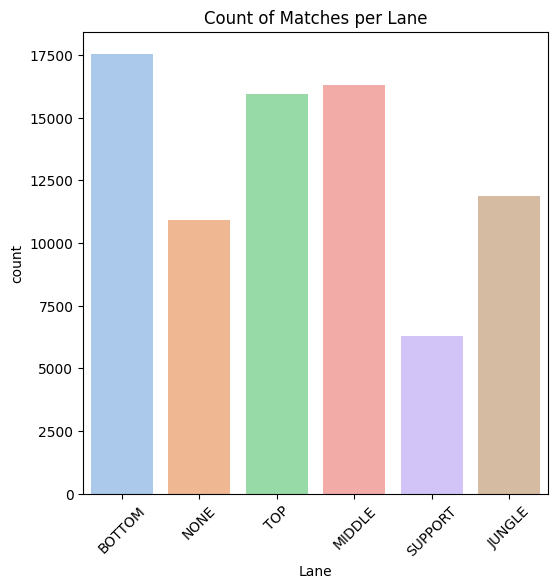

In [24]:
# Pie chart style count plot for the categorical variable 'Lane'
plt.figure(figsize=(6, 6))
sns.countplot(x='Lane', data=MatchStatsTbl, palette='pastel')
plt.title('Count of Matches per Lane')
plt.xticks(rotation=45)
plt.show()

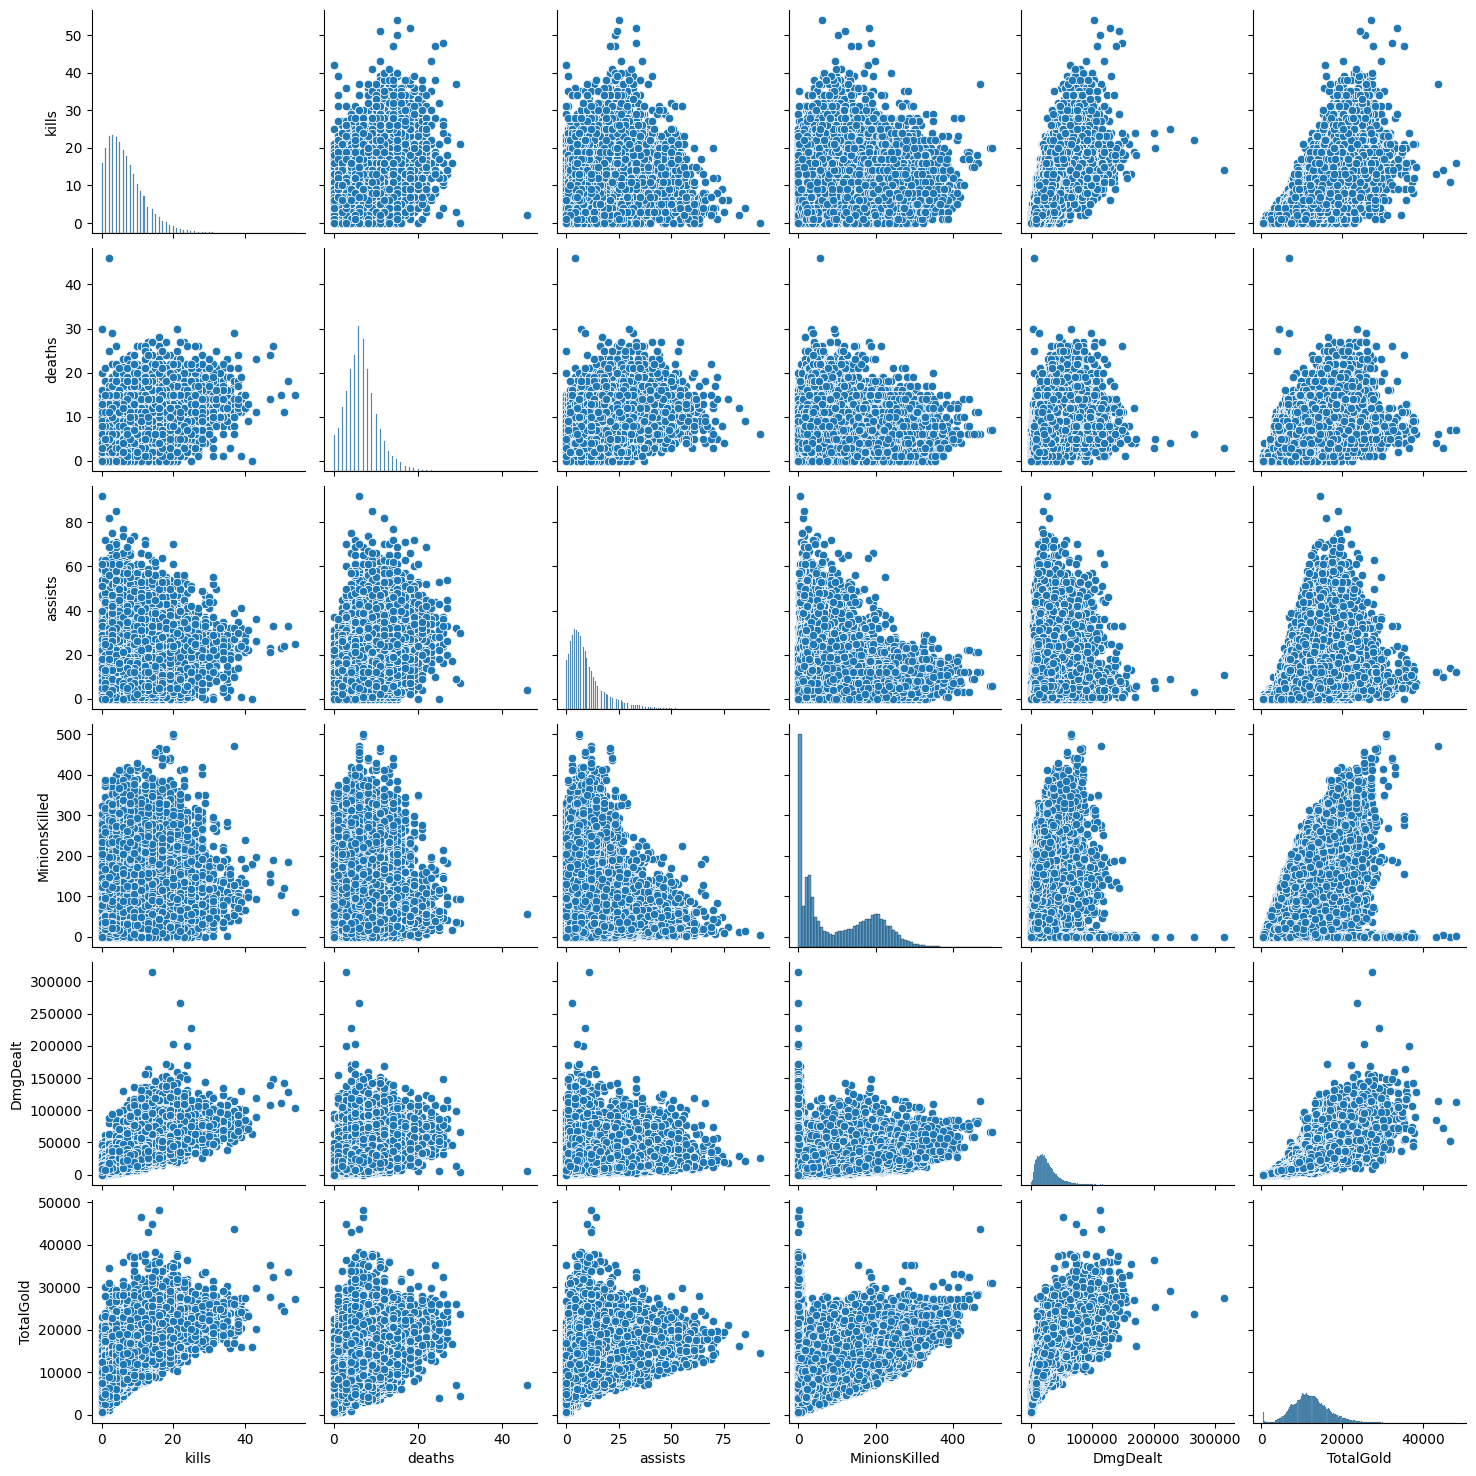

In [27]:
# Pair Plot for a selected subset of metrics
sns.pairplot(MatchStatsTbl[metrics])
plt.show()

### Model Predict

In [ ]:
# We choose features that are likely to influence the outcome: kills, deaths, assists, minions killed, damage metrics, etc.
features = ['kills', 'deaths', 'assists', 'MinionsKilled', 'DmgDealt', 'DmgTaken', 'TotalGold']

# Ensure that the selected features exist in the dataset (defensive programming)
for feature in features:
    if feature not in MatchStatsTbl.columns:
        raise ValueError(f"Feature {feature} not found in matchstats_df")

X = MatchStatsTbl[features]
y = MatchStatsTbl['Win']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_train)

# Calculate prediction accuracy
accuracy = accuracy_score(y_train, y_pred)
print(f'Logistic Regression Prediction Accuracy: {accuracy:.4f}')

Logistic Regression Prediction Accuracy: 0.7805


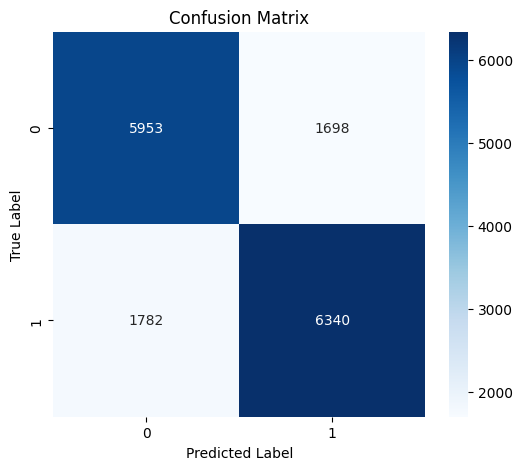

In [31]:
# Confusion Matrix using seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

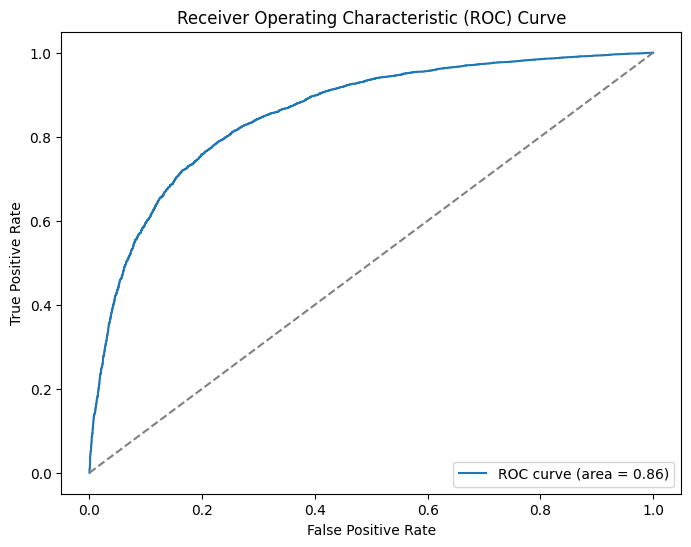

In [32]:
# ROC Curve
y_prob = logreg.predict_proba(X_test)[:, 1]  # probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()